# Preamle

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')
import load_dataset as load
import subphase_calc_functions as subphase_calc
import access_functions as af

import correlation_plots as corr_plot

import access_correlation_functions as access_corr

In [2]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables2()

# Raintype

In [3]:
# This way you don't have to reload all of the datasets if you want to reset them
awap_init = awap.copy(deep = True)
access_init = access.copy(deep = True)

In [4]:
awap = awap_init
access = access_init

In [5]:
import subphase_calc_functions as scf

In [6]:
q = 90

# If q > 0, then awap will be the events above a certian percentile
if q:
    awap = scf.unsplit_find_events_above_q(awap, q)
    
    # Looping through ensemble
    ex_stor = []
    for ensemble in access.ensemble.values:  
        # Selecting a single ensemble
        access_single = access.sel(ensemble = ensemble)
        # Getting extrreme events
        access_90_single = scf.unsplit_find_events_above_q(access_single, q)
        
        ex_stor.append(access_90_single)
    access = xr.concat(ex_stor, pd.Index(access.ensemble.values, name = 'ensemble'))
    
else:
    q = 'all'

In [7]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [8]:
subphase_calc = reload(subphase_calc)
# Split access into the subphases: enhanced, suppressed, transition and inactive.
access_split = af.access_rmm_split(access, rmm_access)

1 2 3 4 5 6 7 8 9 10 11 

# Functions

In [9]:
# This function calculated the Fisher-z Transform of the rho-values, then calculates the mean of the
# z-values. The mean z-value is then converted back into rho-space.

def fisher_z(data):
    
    # Converting all the data to a z-space
    z_space = 0.5 * np.log((1 + data.precip)/(1- data.precip)).to_dataset(name = 'z_val')

    # Taking the mean across the north of Australia
    z_mean = z_space.mean(dim = ['lat','lon'])

    #Getting the mean of all these values
    rho_mean = np.tanh(z_mean.z_val)
    
    return rho_mean
    

In [10]:
def fisher_z_state(data_total): # The mean of all correlation values for each state using the fisher-z transfomr
    
    states = [slice(110,160),slice(110,129),slice(130,138), slice(138, 160)] #Lons for All,WA, NT and QLD respectivly
        
    state_stor = []    

    for state in states:
        data = data_total.sel(lon = state)
        
        # Converting all the data to a z-space
        z_space = 0.5 * np.log((1 + data.precip)/(1- data.precip)).to_dataset(name = 'z_val')

        
        # Taking the mean across the north of Australia
        z_mean = z_space.mean(dim = ['lat','lon'])
        
        #Getting the mean of all these values
        rho_mean = np.tanh(z_mean.z_val)
        
        state_stor.append(rho_mean)
    print(len(state_stor))
    state_means = xr.concat(state_stor, pd.Index(['All','WA','NT','QLD'], name = 'state'))
    return state_means
    

In [11]:
def awap_access_correlation(awap, access):
    
    # Finding the mean across the dimension year
    awap_mean = awap.mean(dim = 'year')
    access_mean = access.mean(dim = 'year')
    
    # Taking the mean from all of the values
    awap_y_sub_mean = awap - awap_mean 
    access_y_sub_mean = access - access_mean 
    
    
    # The covarience: the sum of the product, divfided by the number of samples -1
    cov = (awap_y_sub_mean * access_y_sub_mean).sum(dim = 'year')/(awap_y_sub_mean.count(dim = 'year') - 1)
    
    # the standsard deviation
    awap_std = awap.std(dim = 'year')
    access_std = access.std(dim = 'year')

    # Correlation: cross-covarience divided by the number of samples
    rho = cov/(awap_std * access_std)

    return rho

# Calculation

## Anomaly Calculation

<b> Calculating the number of days in RMM </b>

In [12]:
import access_general_functions as access_general

In [13]:
access_general = reload(access_general)
rmm_count_obs  = access_general.count_in_rmm_subphase_year_month_resample(rmm_obs)

In [14]:
rmm_count_obs

<xarray.Dataset>
Dimensions:  (month: 6, phase: 4, year: 23)
Coordinates:
  * month    (month) int64 1 2 3 10 11 12
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, month, year) float64 16.0 3.0 7.0 10.0 ... 12.0 9.0 22.0

<b> AWAP </b>

In [15]:
# Count
access_corr = reload(access_corr)
count_anom = access_corr.count_month_year_anomalies(awap_split, awap, rmm_count_obs)

In [16]:
# Sum
access_corr = reload(access_corr)
sum_anom = access_corr.sum_month_year_anomalies(awap_split, awap, rmm_count_obs)

In [17]:
# mean
access_corr = reload(access_corr)
mean_anom = access_corr.mean_month_year_anomalies(awap_split, awap, rmm_count_obs)

<b> ACCESS-S </b>

In [18]:
# Count
access_general = reload(access_general)
access_corr = reload(access_corr)
count_anom_ens, count_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.count_month_year_anomalies)

In [19]:
# Sum
access_general = reload(access_general)
access_corr = reload(access_corr)
sum_anom_ens, sum_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.sum_month_year_anomalies)

In [20]:
# mean
access_general = reload(access_general)
access_corr = reload(access_corr)
mean_anom_ens, mean_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.mean_month_year_anomalies)

## Correlation Calculations

In [21]:
'''Count'''
# Spearman Correlation
access_corr = reload(access_corr)
spearman_count, sig_count = access_corr.spearman_correlation(count_anom,count_anom_ens_med)

# Pearsons
rho_count = awap_access_correlation(count_anom,count_anom_ens_med)

In [22]:
'''Sum'''
# Spearman Correlation
access_corr = reload(access_corr)
spearman_sum, sig_sum = access_corr.spearman_correlation(sum_anom,sum_anom_ens_med)

# Pearsons
rho_sum = awap_access_correlation(sum_anom,sum_anom_ens_med)

In [23]:
'''mean'''
# Spearman Correlation
access_corr = reload(access_corr)
spearman_mean, sig_mean = access_corr.spearman_correlation(mean_anom,mean_anom_ens_med)

# Pearsons
rho_mean = awap_access_correlation(mean_anom,mean_anom_ens_med)

Fisher-Z transform

In [24]:
'''Count'''

# This is the mean of the fisher z for all data
rho_mean_count = fisher_z(rho_count)
# This is for all states AND also for overall
rho_state_count = fisher_z_state(rho_count)

4


In [25]:
'''Sum'''
# This is the mean of the fisher z for all data
rho_mean_sum = fisher_z(rho_sum)
# This is for all states AND also for overall
rho_state_sum = fisher_z_state(rho_sum)

4


In [26]:
'''mean'''
# This is the mean of the fisher z for all data
rho_mean_mean = fisher_z(rho_mean)
# This is for all states AND also for overall
rho_state_mean = fisher_z_state(rho_mean)

4


# Plots

In [43]:
savedir = '../images_2/'

### Single Maps

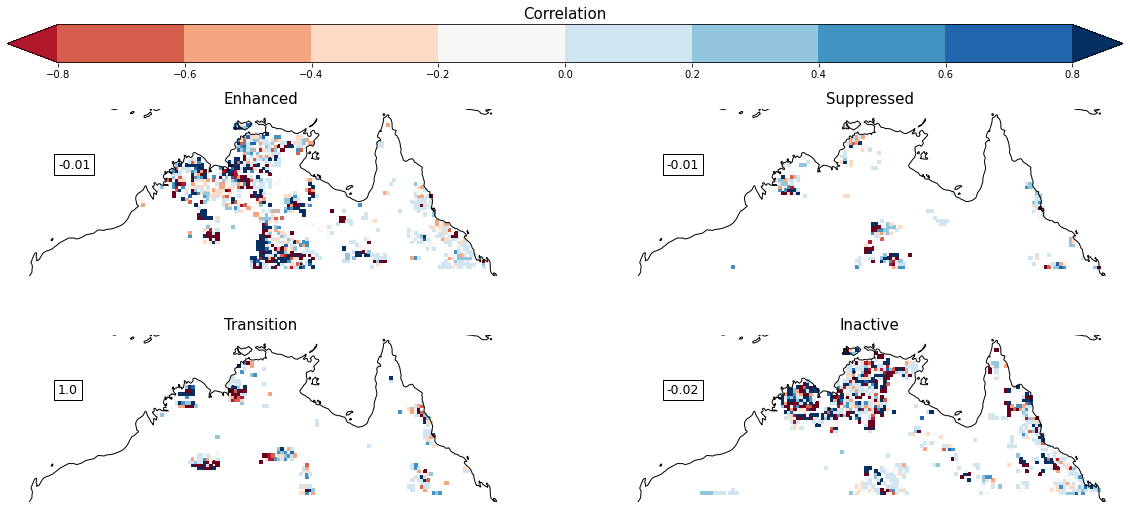

In [22]:
corr_plot = reload(corr_plot)
month = 10
save_name = f'mean_{calendar.month_name[month]}'
corr_plot.corr_plot(rho_mean.sel(month = month), # Correlation values
                    sig_mean.sel(month = month), # The location of the significant points
                    means = rho_mean_mean.sel(month = month), # The mean for the phase
                    sig_size = 4.5, add_white = 0, extender = 0) # some mods
#                     savetitle = save_name)

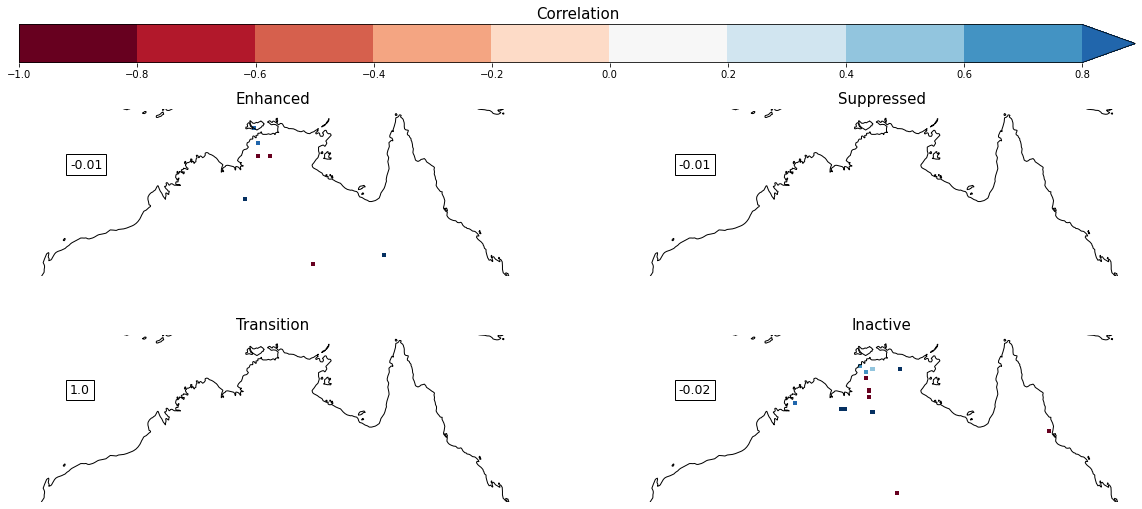

In [23]:
corr_plot = reload(corr_plot)
month = 10
save_name = f'mean_{calendar.month_name[month]}'
corr_plot.corr_plot_sig_only(spearman_mean.sel(month = month), # Correlation values
                    sig_mean.sel(month = month), # The location of the significant points
                    means = rho_mean_mean.sel(month = month), # The mean for the phase
                    sig_size = 4.5, add_white = 0, extender = 0) # some mods
#                     savetitle = save_name)

In [174]:
# corr_plot = reload(corr_plot)
# for month in [10,11,12,1,2,3]:
#     save_name = f'percent_{calendar.month_name[month]}_sig'
#     corr_plot.corr_plot_sig_only(spearman_percent.sel(month = month), 
#                         sig_percent.sel(month = month),
#                         means = rho_p_mean.sel(month = month)
#                         ,savetitle = save_name, savedir = savedir_percent)

### Multi-Maps

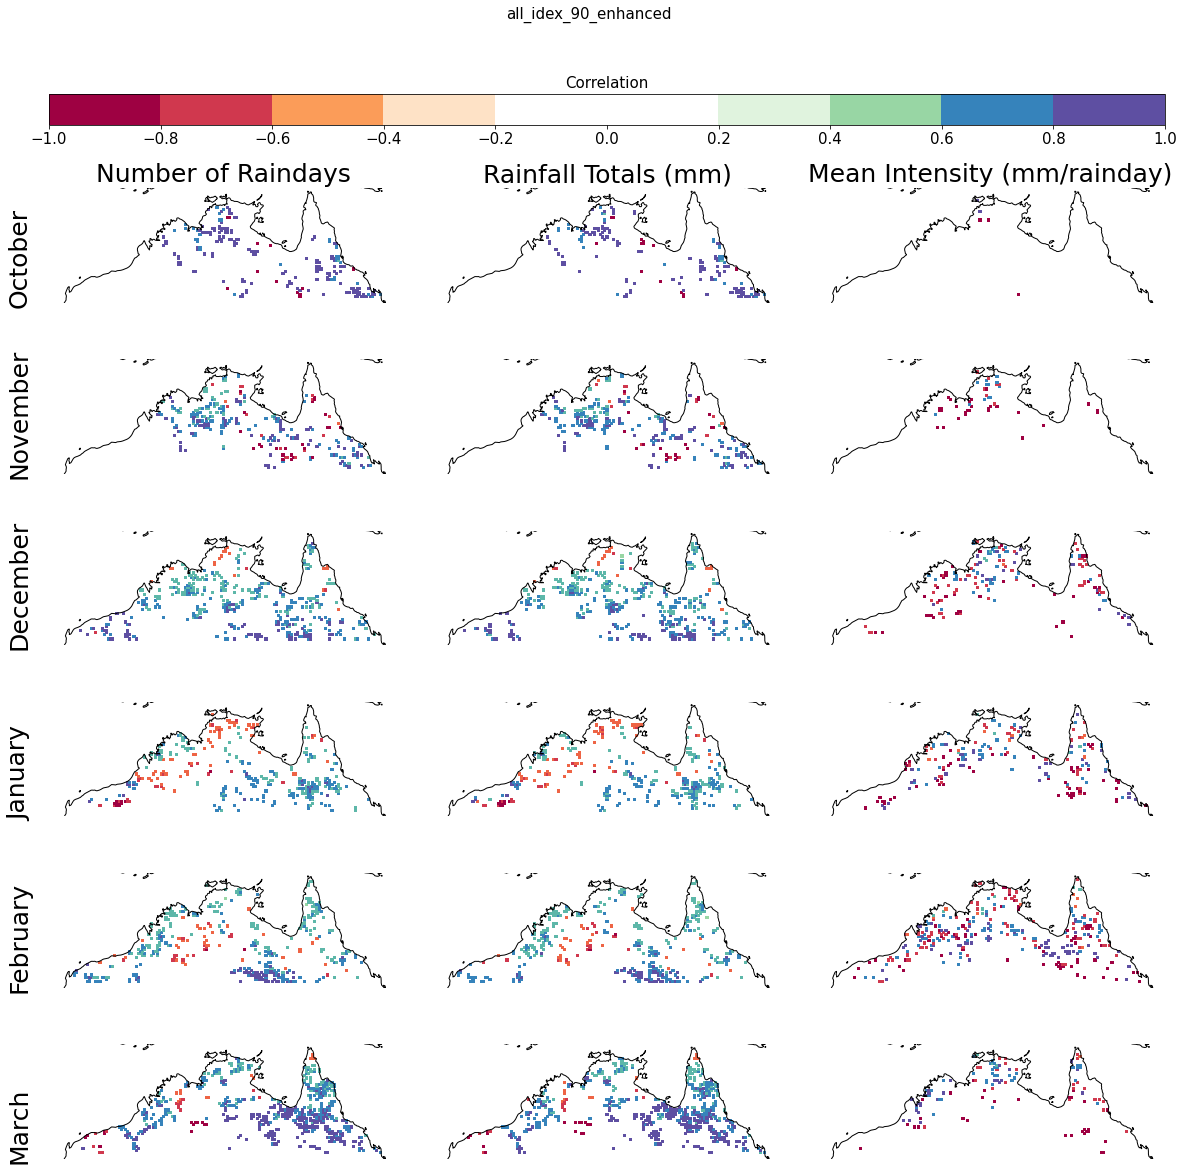

In [31]:
corr_plot = reload(corr_plot)
phase = 'enhanced'
savetitle = f'all_idex_{q}_{phase}'
corr_plot.correlation_plot_single_phase_multi_indinice_sig_only([ spearman_count,spearman_sum, spearman_mean],
                                            [ sig_count,sig_sum, sig_mean],
                                             ['Number of Raindays','Rainfall Totals (mm)','Mean Intensity (mm/rainday)'], 
                                                                phase = phase,
                                                                add_white = 1, vmax = 1, step = 0.2, 
                                                                cmap_init = 'Spectral',
                                                      savetitle = savetitle)

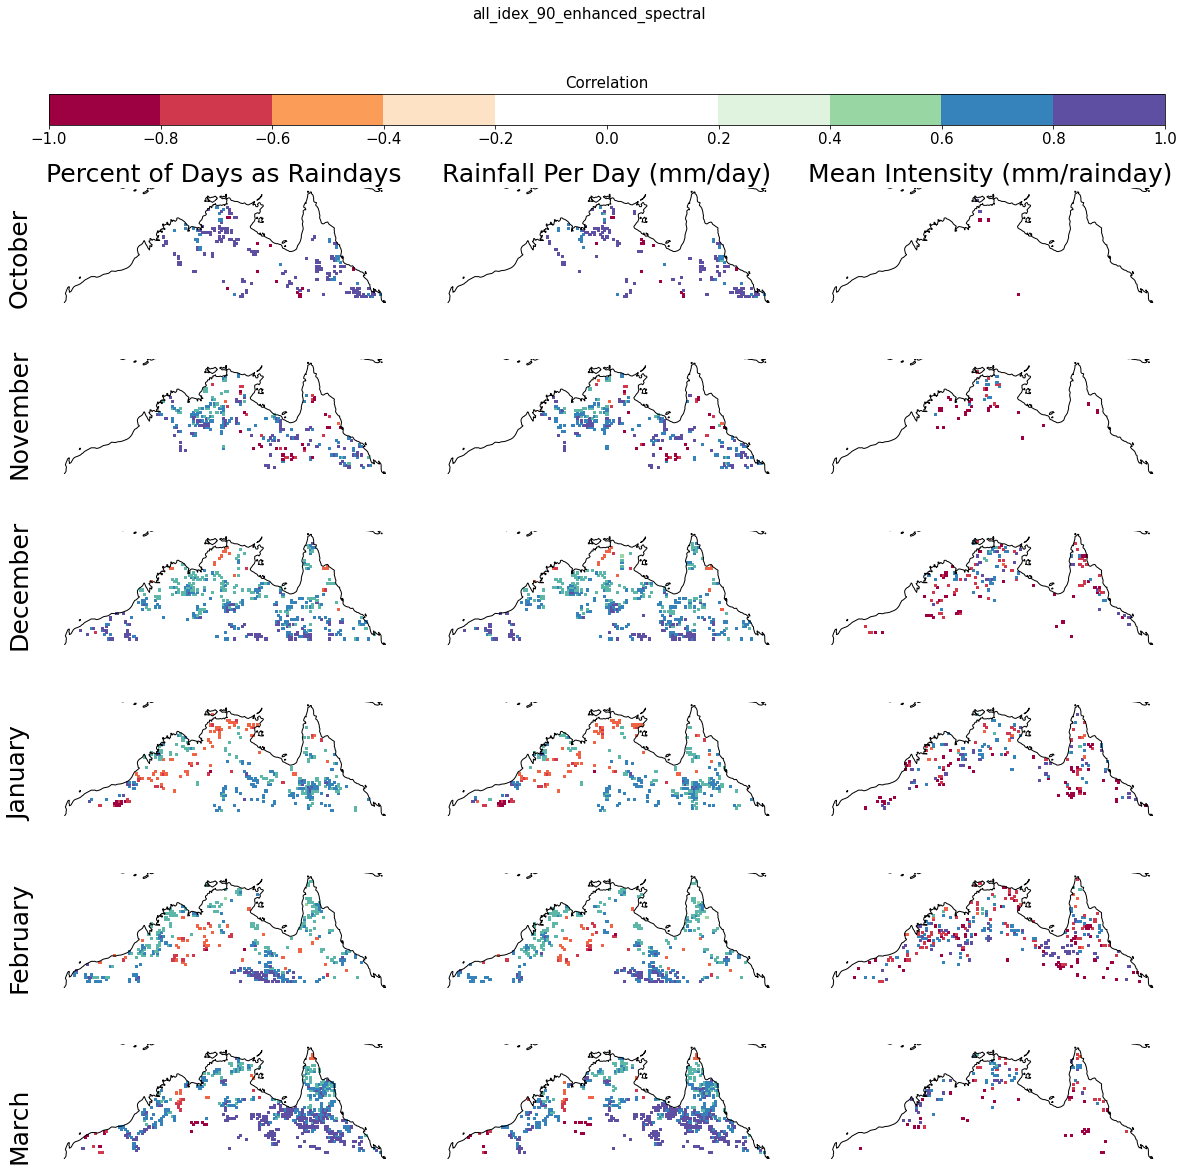

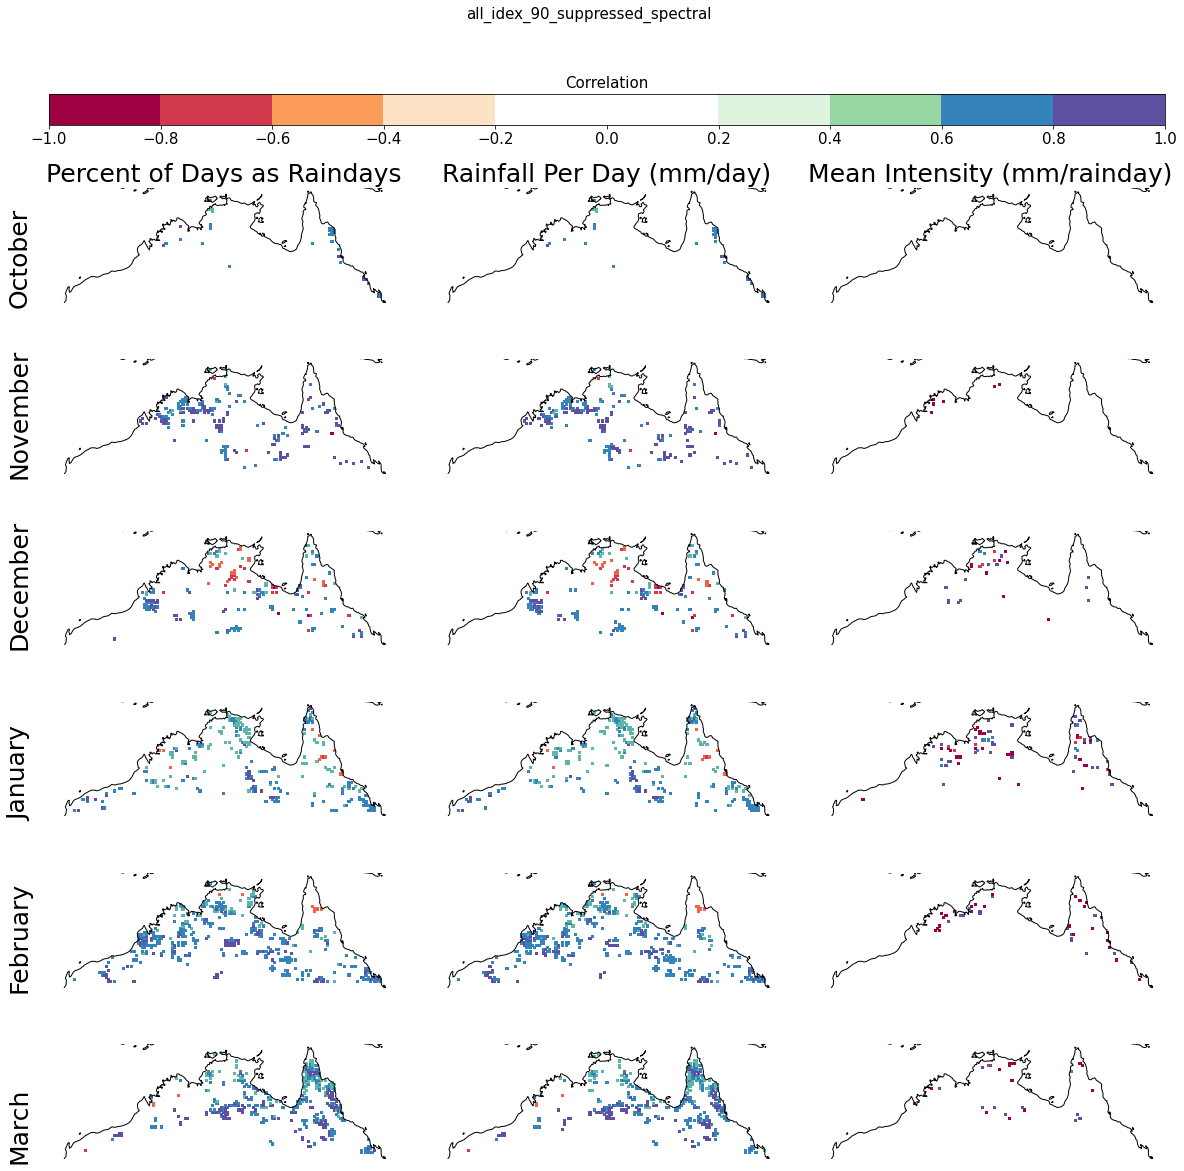

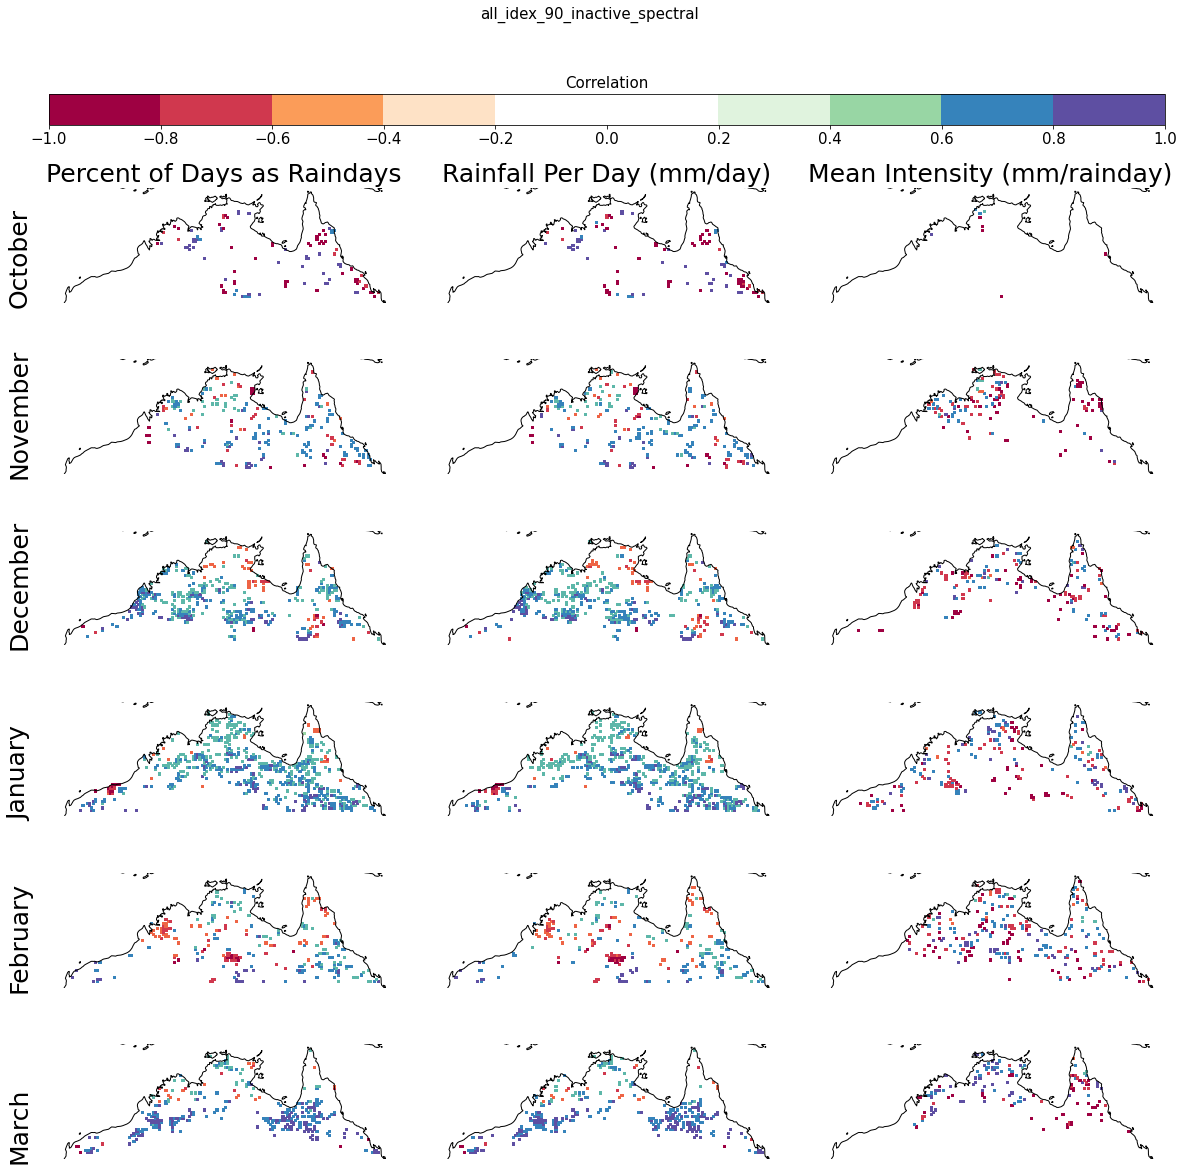

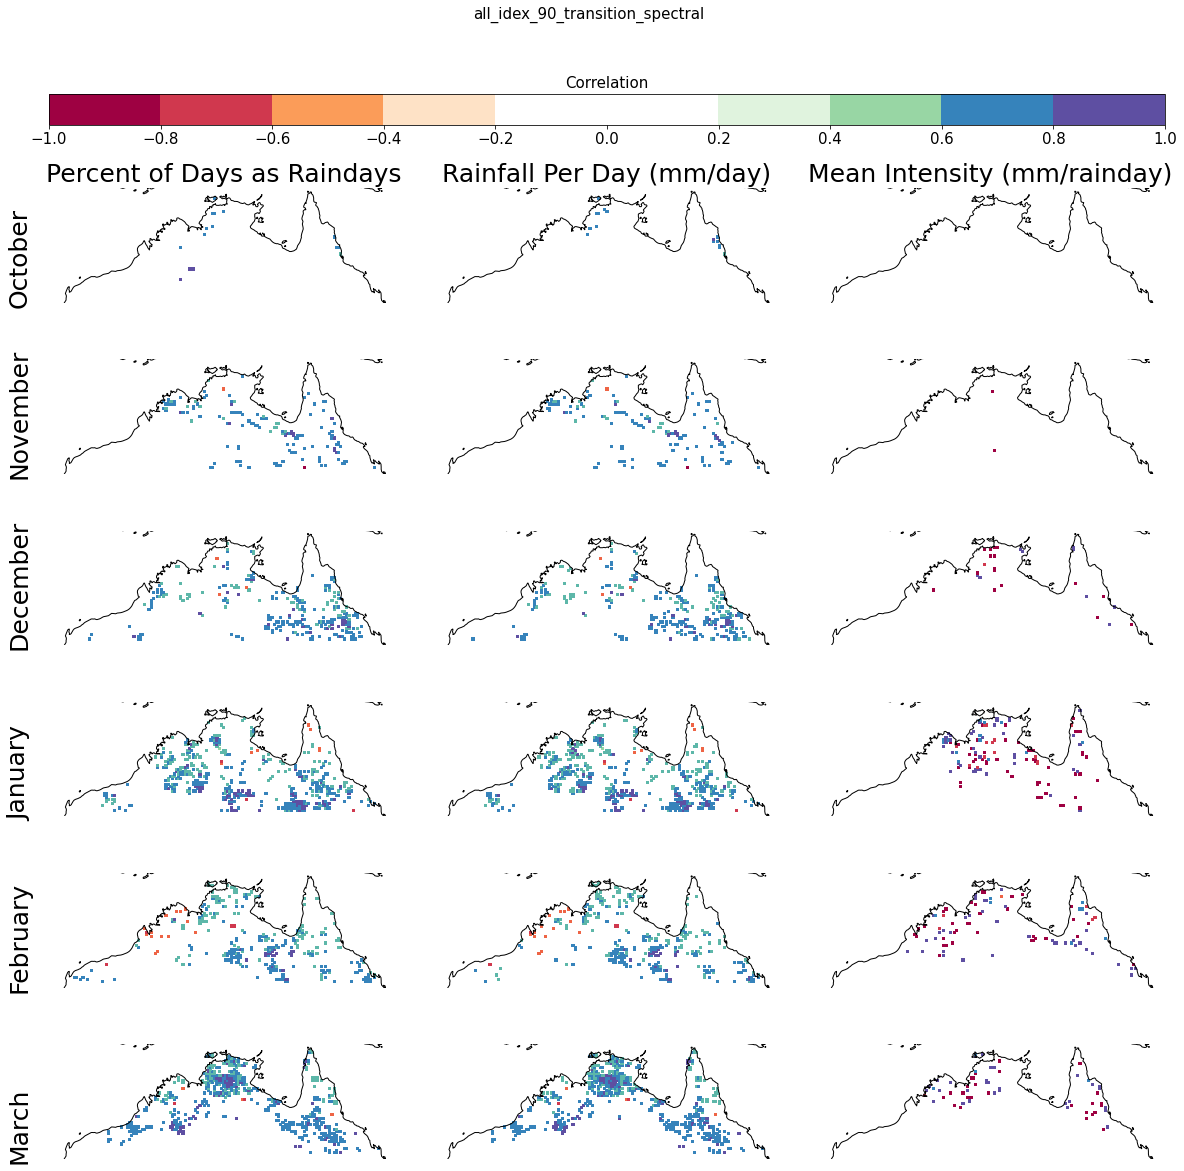

In [32]:
for phase in ['enhanced','suppressed', 'inactive', 'transition']:
    savetitle = f'all_idex_{q}_{phase}_spectral'
    corr_plot.correlation_plot_single_phase_multi_indinice_sig_only([ spearman_count,spearman_sum, spearman_mean],
                                                           [ sig_count,sig_sum, sig_mean],
                                                 ['Percent of Days as Raindays','Rainfall Per Day (mm/day)',
                                                  'Mean Intensity (mm/rainday)'], 
                                                                    phase = phase, cmap_init = 'Spectral',
                                                                    vmax = 1, step = 0.2, add_white = 1,
                                                          savetitle = savetitle
                                                                   ,savedir = savedir)

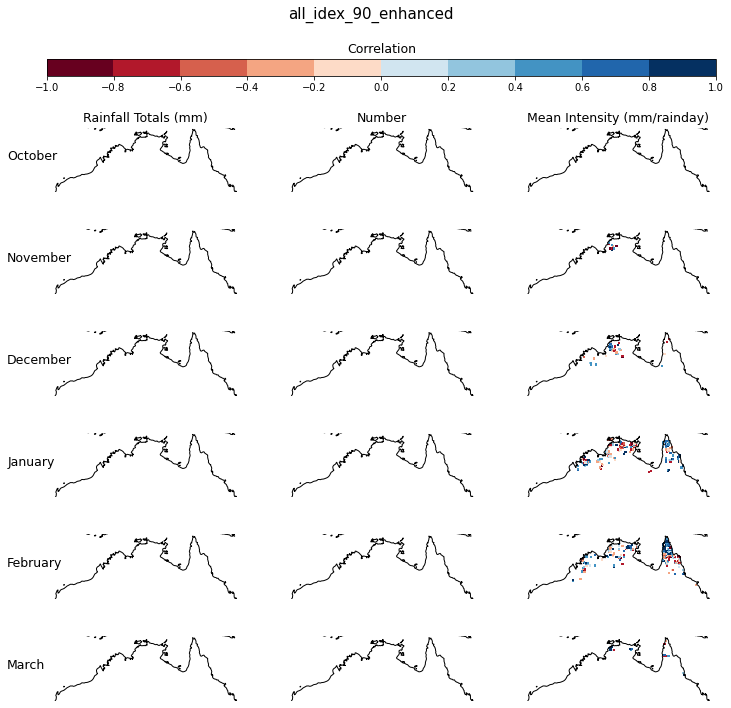

In [177]:
corr_plot = reload(corr_plot)
phase = 'enhanced'
savetitle = f'all_idex_{q}_{phase}'
corr_plot.correlation_plot_single_phase_multi_indinice([spearman_sum, spearman_count, spearman_mean],
                                             ['Rainfall Totals (mm)','Number','Mean Intensity (mm/rainday)'], 
                                                      savetitle = savetitle)

### Heatmaps

In [28]:
import access_heatmaps_corr as heat_corr

This is a test function to work out kinks that is minised below

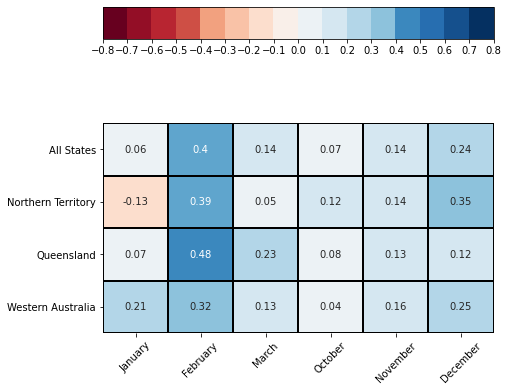

In [179]:
month_reverse = 0
import seaborn as sns
import matplotlib as mpl
state_id = {'All':'All States','NT':'Northern Territory','QLD':'Queensland','WA':'Western Australia'}
vmax = 0.8
vmin = -vmax
step = 0.1


# Construction the colormap
levels = np.arange(vmin, vmax + step, step)
cmap = plt.cm.get_cmap('RdBu', len(levels) + 1)


fig = plt.figure(figsize = (7, 6))
gs = gridspec.GridSpec(2,1, hspace = 0.7, height_ratios = [0.15,1])


ax = fig.add_subplot(gs[1])



# Making sure the months are in the correct order: not 1,2,3,10,11,12
if month_reverse:
    plot_vals = np.concatenate([plot_vals[:,3:], plot_vals[:,0:3]], axis = 1)



sns.heatmap(plot_vals.round(2), ax = ax,
            cmap = cmap, vmax = vmax, vmin = vmin, cbar = False, 
           annot = True, linewidths = 1, linecolor = 'k')

ax.set_yticklabels(list(state_id.values()), rotation = 360);
month_names = [calendar.month_name[i] for i in data.month.values]
if month_reverse:
    month_names= np.concatenate([month_names[3:], month_names[0:3]])
ax.set_xticklabels(month_names, rotation = 45);



axes = plt.subplot(gs[0])
cbar = mpl.colorbar.ColorbarBase( axes,cmap = cmap, orientation = 'horizontal',
                    ticks  = levels, boundaries = levels)


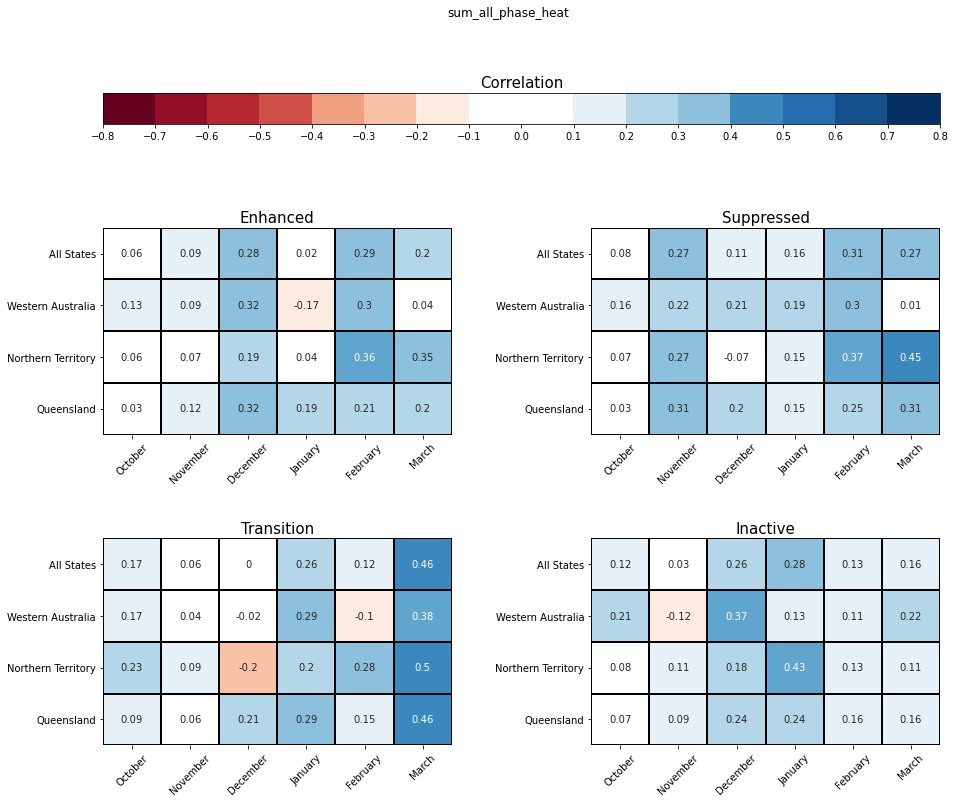

In [66]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_phase_group(rho_state_sum, month_reverse = 1
                 , vmax = 0.8,step = 0.1, add_white = 1
                 ,savename = f'sum_{q}_phase_heat', savedir = savedir)

In [27]:
rho_state_mean

<xarray.DataArray 'z_val' (state: 4, month: 6, phase: 4)>
array([[[ 9.57079650e-03,  2.01026171e-02, -8.13578679e-03,
          5.37422298e-03],
        [ 8.41067710e-03, -2.27371347e-02,  3.28619164e-02,
          1.50634917e-02],
        [ 2.79798216e-02,             nan,  3.32834158e-02,
          2.54162362e-02],
        [-1.31936891e-02, -1.26695264e-02,  1.00000000e+00,
         -2.35310311e-02],
        [ 1.15971576e-02,  2.70402361e-02, -1.99094231e-03,
          7.14267879e-03],
        [-2.38730445e-02,  1.86099451e-02,  1.71374955e-02,
         -2.90113735e-03]],

       [[ 2.33140014e-05, -7.81146078e-03, -1.66379734e-03,
          1.44542350e-02],
        [-1.01658125e-02, -1.04978297e-02,  2.27704999e-02,
          6.78772728e-03],
        [ 5.62468751e-02,  6.40772739e-03,  1.20982332e-02,
          1.01343797e-02],
        [-6.15871488e-02,  6.38670515e-02,  7.71185427e-02,
         -2.85419439e-02],
        [-3.27431108e-02, -1.62842884e-02,  8.74764915e-02,
          3.19581999e-02],
        [-6.29196935e-02,  3.81283031e-02,  8.39552508e-02,
         -2.49583329e-02]],

       [[ 7.25297974e-03,  1.25561372e-03, -3.62747498e-02,
          3.10233553e-03],
        [ 1.69304307e-02, -4.47878375e-02,  1.52634902e-02,
          1.44672703e-02],
        [ 5.48083997e-02,             nan,  6.32427729e-02,
          4.98253594e-02],
        [ 1.22706489e-02, -8.23725635e-02, -8.70775100e-02,
         -3.38726583e-02],
        [ 2.39343823e-02,  2.74952550e-02, -4.72896225e-02,
          9.90595490e-04],
        [ 7.32455844e-03,  5.44861124e-02, -6.89357309e-02,
          2.70590460e-03]],

       [[ 2.04309857e-02,  6.75609353e-02,  1.98463857e-02,
         -7.97922401e-03],
        [ 1.29713462e-02, -1.84870689e-02,  5.42445854e-02,
          1.91020828e-02],
        [-2.89103500e-02,  2.16226631e-02,  3.46068728e-02,
          7.26475139e-03],
        [-1.59369689e-02,  7.04646821e-02,  1.00000000e+00,
          5.80197141e-04],
        [ 1.26855797e-02,  7.17872657e-02,  3.22616640e-02,
          1.34735522e-02],
        [-2.85796827e-02, -1.76465131e-02,  2.35534108e-02,
          3.69258370e-04]]])
Coordinates:
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * state    (state) object 'All' 'WA' 'NT' 'QLD'

In [32]:
rho_state_mean = rho_state_mean.where(rho_state_mean < 0.5, 0)

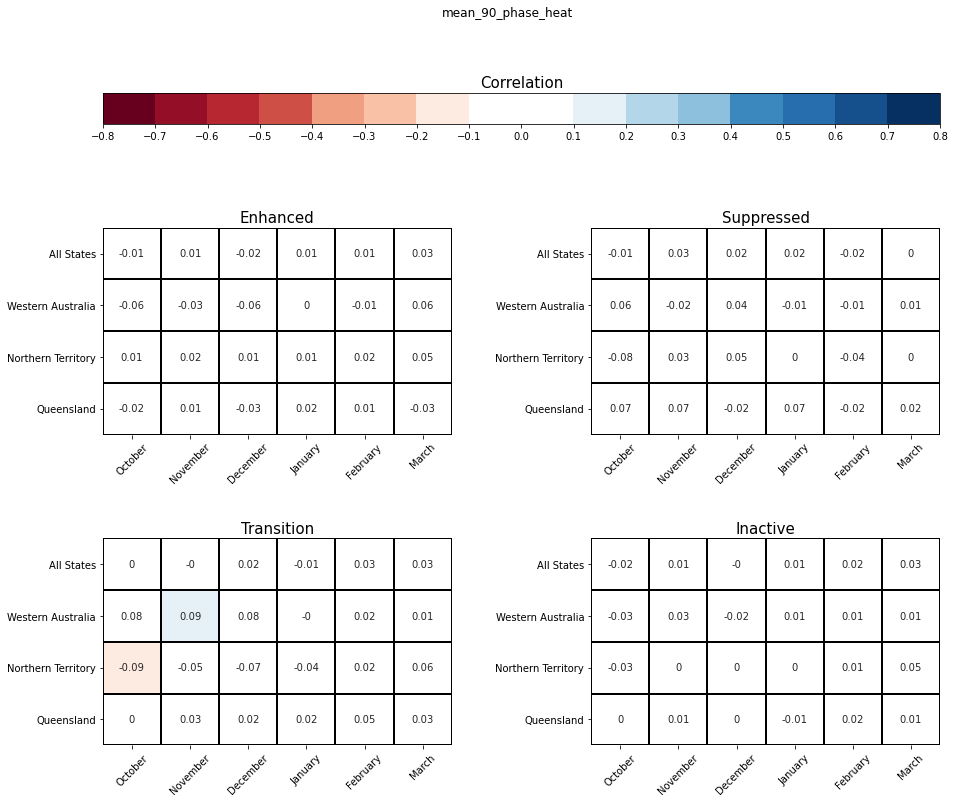

In [36]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_phase_group(rho_state_mean, month_reverse = 1
                 , vmax = 0.8,step = 0.1, add_white = 1
                 ,savename = f'mean_{q}_phase_heat', savedir = savedir)

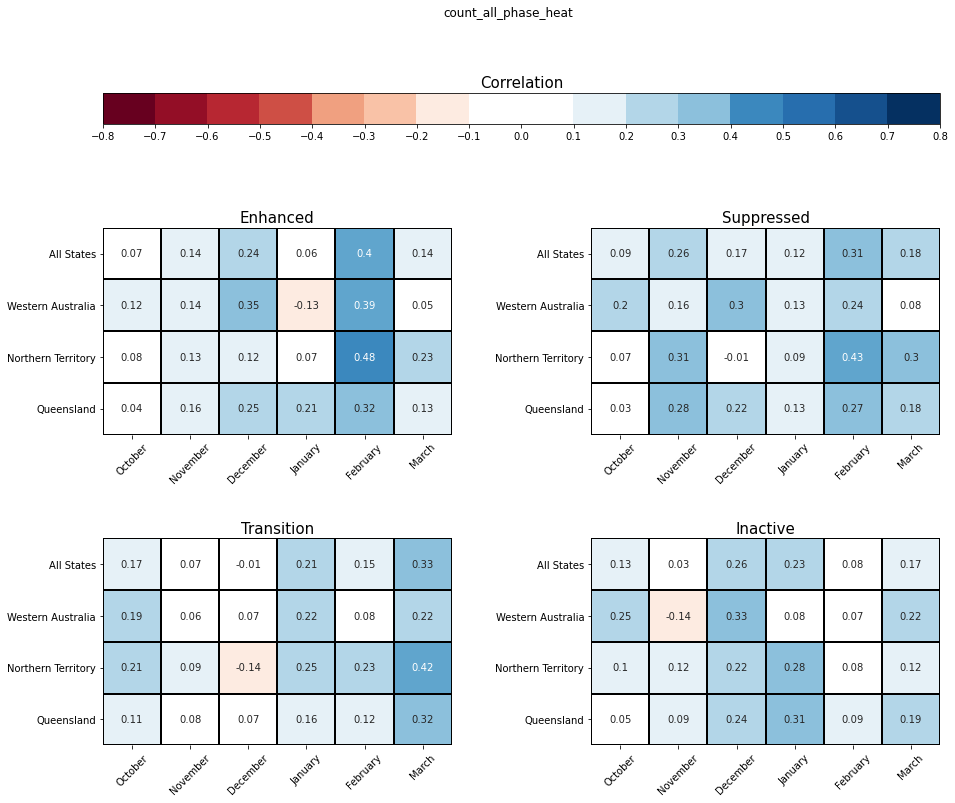

In [68]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_phase_group(rho_state_count, month_reverse = 1
                 , vmax = 0.8,step = 0.1, add_white = 1
                 ,savename = f'count_{q}_phase_heat', savedir = savedir)

## Legion Heatmap

In [29]:
rho_state_count

<xarray.DataArray 'z_val' (state: 4, month: 6, phase: 4)>
array([[[ 4.59356644e-02,  4.33837883e-02,  1.32037554e-01,
          1.89813186e-01],
        [ 1.12917153e-01,  1.31478935e-01,  6.00003767e-02,
          4.29440008e-02],
        [ 1.36220739e-01,  1.67179615e-01,  2.83740920e-01,
          1.01604147e-01],
        [ 1.10573987e-01,  1.22484977e-01, -5.13799765e-02,
          3.40956072e-02],
        [-6.94853296e-03,  1.27210644e-01, -1.85539313e-02,
         -1.96491941e-02],
        [ 1.27424383e-01, -3.26611048e-02,  6.53415922e-02,
          1.15077497e-01]],

       [[-5.29732641e-02, -2.71305234e-04,  9.69375950e-02,
          3.50430037e-02],
        [ 1.27828635e-01,  1.40723933e-01, -2.10023841e-02,
          7.37399442e-03],
        [-2.30424214e-02,  2.05628947e-03,  2.10779222e-01,
          9.26028377e-02],
        [ 8.15384752e-02,  2.00361826e-01,  1.75415840e-02,
          1.84598884e-01],
        [ 6.77269093e-02,  1.23290112e-01, -1.24771872e-01,
         -3.36186656e-03],
        [ 1.59571445e-01, -1.02531710e-02, -3.18358944e-02,
          2.27763343e-01]],

       [[-1.32887944e-03,  7.21480358e-02,  1.29375199e-01,
          2.43194847e-01],
        [ 8.74314363e-02,  1.99775742e-01,  1.21088876e-01,
          5.88843240e-02],
        [ 1.00101204e-01,  2.78997250e-01,  3.23728763e-01,
          1.73851866e-02],
        [ 1.83229720e-02,  7.21719182e-02, -9.85651766e-02,
         -7.39255056e-02],
        [ 6.53661704e-03,  1.21566702e-01, -2.53015288e-02,
         -3.70164704e-02],
        [ 8.65402767e-02, -1.84176928e-03,  3.10914085e-03,
          2.88426994e-02]],

       [[ 1.78145722e-01,  4.91928351e-02,  1.56785923e-01,
          2.55501127e-01],
        [ 1.41435328e-01,  7.17511734e-02,  6.93885846e-02,
          5.59884148e-02],
        [ 3.06189569e-01,  2.15678325e-01,  2.82548794e-01,
          2.00311368e-01],
        [ 2.06921757e-01,  1.23119550e-01, -4.21932537e-02,
          1.93478415e-02],
        [-6.34164863e-02,  1.37400759e-01,  2.28926589e-02,
         -7.95814174e-03],
        [ 1.30698268e-01, -7.27132597e-02,  2.03834782e-01,
          1.05553779e-01]]])
Coordinates:
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * state    (state) object 'All' 'WA' 'NT' 'QLD'

In [38]:
rho_state_mean2 = rho_state_mean.copy(deep = True)

In [39]:
rho_state_mean2 = rho_state_mean2.where(rho_state_mean < 0.5, 0)

In [47]:
savedir = '../images_2/'

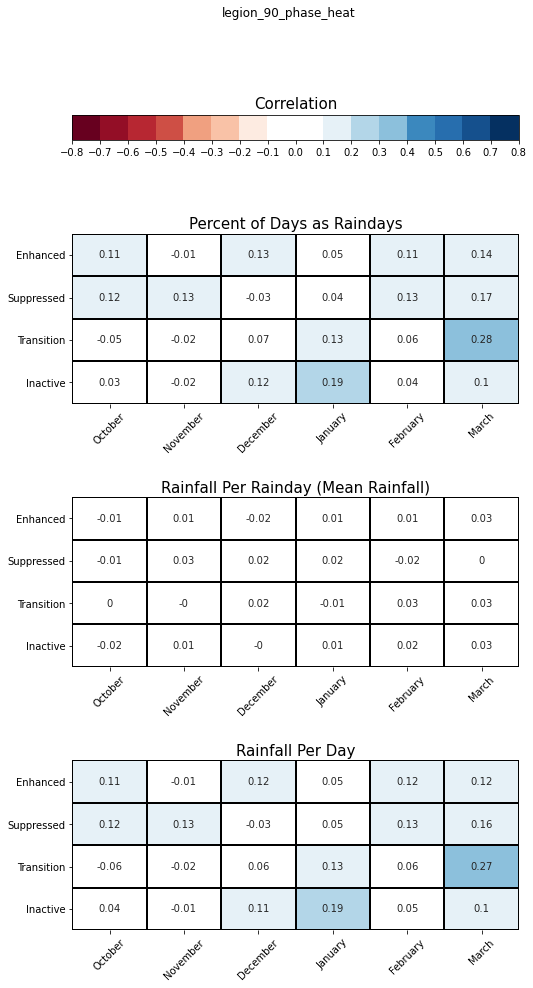

In [48]:
heat_corr = reload(heat_corr)
data_tot = [rho_state_count.sel(state = 'All').transpose(),
            rho_state_mean2.sel(state = 'All').transpose(), 
            rho_state_sum.sel(state = 'All').transpose()]

titles = ['Percent of Days as Raindays', 'Rainfall Per Rainday (Mean Rainfall)','Rainfall Per Day']

heat_corr.corr_heatmap_multi_index(data_tot, titles = titles, month_reverse = 1
                 , vmax = 0.8,step = 0.1, add_white = 1
                 ,savename = f'legion_{q}_phase_heat', savedir = savedir)